In [35]:
# FULL PIPELINE FOR: /kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv
# Paste this into a notebook cell and run (Kaggle / Colab / local with dataset available).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# sklearn utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report


In [36]:
# -----------------------
# 1) Load dataset
# -----------------------
CSV_PATH = "/content/predictive_maintenance.csv"

df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)
display(df.head())

# -----------------------
# 2) Quick EDA / cleanup
# -----------------------
print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

Dataset shape: (10000, 10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Columns and dtypes:
 UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

Missing values per column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [37]:
# If any missing values, drop or fill (small dataset: drop rows with NA)
if df.isna().sum().sum() > 0:
    df = df.dropna().reset_index(drop=True)
    print("Dropped rows with NA, new shape:", df.shape)

# Inspect target distribution
# The Kaggle dataset's label column might be 'failure_type' or 'Failure Type' or similar;
# we'll try to guess common names. Print unique columns and search for plausible target columns.
print("\nColumns:", df.columns.tolist())

# Try to infer label column:
possible_label_cols = [c for c in df.columns if 'failure' in c.lower() or 'failure_type' in c.lower() or 'type' in c.lower()]
print("Possible label columns:", possible_label_cols)

# If you know the label column name, override label_col here:
# Example: label_col = 'Failure Type'
# For this dataset the likely label column is 'failure_type' or 'failure' — choose the first that matches.
label_col = None
for c in df.columns:
    if 'failure' in c.lower():
        label_col = c
        break
if label_col is None:
    # fallback: ask to use last column as label
    label_col = df.columns[-1]
print("Using label column:", label_col)


Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']
Possible label columns: ['Type', 'Failure Type']
Using label column: Failure Type


In [38]:
# Features = all numeric columns except label
# Drop any non-numeric columns (timestamp, id) if present
numeric_df = df.select_dtypes(include=[np.number]).copy()
if label_col in numeric_df.columns:
    # label is numeric? keep separate
    X = numeric_df.drop(columns=[label_col]).copy()
    y = df[label_col].copy()
else:
    # label is not numeric or label column is outside numeric set
    X = numeric_df.copy()
    y = df[label_col].copy()

print("Features shape:", X.shape)
print("Label distribution before encoding:", Counter(y))


Features shape: (10000, 7)
Label distribution before encoding: Counter({'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18})


In [39]:
# -----------------------
# 3) Encode target & scale features
# -----------------------
le = LabelEncoder()
y_enc = le.fit_transform(y.astype(str))
print("Encoded classes:", le.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Encoded classes: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']


In [40]:
# -----------------------
# 4) Train / test split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label distribution:", Counter(y_train))


Train shape: (8000, 7) Test shape: (2000, 7)
Train label distribution: Counter({np.int64(1): 7722, np.int64(0): 90, np.int64(3): 76, np.int64(2): 62, np.int64(5): 36, np.int64(4): 14})


In [41]:
# -----------------------
# 5) Balance training set via upsampling (simple augmentation for tabular)
# -----------------------
# Convert to DataFrame for convenience
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df[label_col] = y_train

# Upsample minority classes
major_class_count = train_df[label_col].value_counts().max()
dfs = []
for cls, group in train_df.groupby(label_col):
    if len(group) < major_class_count:
        up = resample(group, replace=True, n_samples=major_class_count, random_state=42)
        dfs.append(up)
    else:
        dfs.append(group)
train_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced[X.columns].values
y_train_bal = train_balanced[label_col].values
print("Balanced train distribution:", Counter(y_train_bal))


Balanced train distribution: Counter({np.int64(2): 7722, np.int64(3): 7722, np.int64(4): 7722, np.int64(1): 7722, np.int64(0): 7722, np.int64(5): 7722})


In [42]:
# -----------------------
# 6) Convert to PyTorch tensors & DataLoaders
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

BATCH_SIZE = 64
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_enc))

Using device: cuda


In [43]:
# -----------------------
# 7) Model definitions
# -----------------------
class BaseClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DropoutClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DropoutClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dp1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dp2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.dp1(self.fc1(x)))
        x = torch.relu(self.dp2(self.fc2(x)))
        return self.fc3(x)

class BatchNormClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BatchNormClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

class L2Classifier(BaseClassifier):
    pass

class CombinedClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CombinedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dp1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = torch.relu(self.dp1(self.bn1(self.fc1(x))))
        x = torch.relu(self.dp2(self.bn2(self.fc2(x))))
        return self.fc3(x)

In [44]:
# -----------------------
# 8) Training & evaluation helpers
# -----------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for Xb, yb in loader:
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for Xb, yb in loader:
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item() * Xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    avg_loss = running_loss / total
    acc = correct / total
    if len(all_preds) > 0:
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
    else:
        all_preds = np.array([])
        all_labels = np.array([])
    return avg_loss, acc, all_preds, all_labels

def train_with_history(model, optimizer, criterion, train_loader, test_loader, epochs=25, device=device):
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }
    model.to(device)
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        # simple verbose
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:02d}/{epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | test_loss={test_loss:.4f} test_acc={test_acc:.4f}")
    return history

In [45]:
# -----------------------
# 9) Train all models and collect metrics
# -----------------------
EPOCHS = 25
LR = 1e-3

models_info = {
    'Base Model': {'class': BaseClassifier, 'kwargs': {}},
    'With Dropout': {'class': DropoutClassifier, 'kwargs': {}},
    'With BatchNorm': {'class': BatchNormClassifier, 'kwargs': {}},
    'With L2 Regularization': {'class': L2Classifier, 'kwargs': {}},
    'Combined Regularization': {'class': CombinedClassifier, 'kwargs': {}}
}

trained_models = {}
histories = {}
final_test_accuracies = {}

criterion = nn.CrossEntropyLoss()

for name, info in models_info.items():
    print("\n========== Training:", name, "==========")
    model = info['class'](input_size, num_classes).to(device)
    # L2 uses weight_decay in optimizer
    if name == 'With L2 Regularization':
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
    else:
        optimizer = optim.Adam(model.parameters(), lr=LR)
    history = train_with_history(model, optimizer, criterion, train_loader, test_loader, epochs=EPOCHS, device=device)
    _, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
    print(f"Final test accuracy for {name}: {test_acc:.4f}")
    trained_models[name] = model
    histories[name] = history
    final_test_accuracies[name] = test_acc


========== Training: Base Model ==========
Epoch 01/25 | train_loss=0.3072 train_acc=0.8943 | test_loss=0.2221 test_acc=0.8960
Epoch 05/25 | train_loss=0.0143 train_acc=0.9973 | test_loss=0.1216 test_acc=0.9885
Epoch 10/25 | train_loss=0.0062 train_acc=0.9983 | test_loss=0.1655 test_acc=0.9910
Epoch 15/25 | train_loss=0.0034 train_acc=0.9993 | test_loss=0.2056 test_acc=0.9940
Epoch 20/25 | train_loss=0.0069 train_acc=0.9982 | test_loss=0.2399 test_acc=0.9935
Epoch 25/25 | train_loss=0.0034 train_acc=0.9991 | test_loss=0.2550 test_acc=0.9915
Final test accuracy for Base Model: 0.9915

========== Training: With Dropout ==========
Epoch 01/25 | train_loss=0.4545 train_acc=0.8154 | test_loss=0.3204 test_acc=0.8015
Epoch 05/25 | train_loss=0.0861 train_acc=0.9717 | test_loss=0.1610 test_acc=0.9400
Epoch 10/25 | train_loss=0.0382 train_acc=0.9886 | test_loss=0.1469 test_acc=0.9710
Epoch 15/25 | train_loss=0.0251 train_acc=0.9929 | test_loss=0.1459 test_acc=0.9855
Epoch 20/25 | train_loss=0.

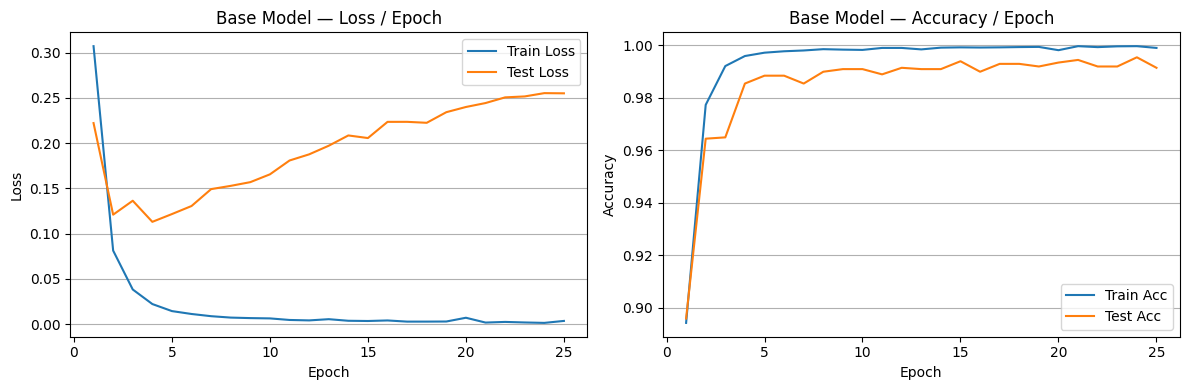

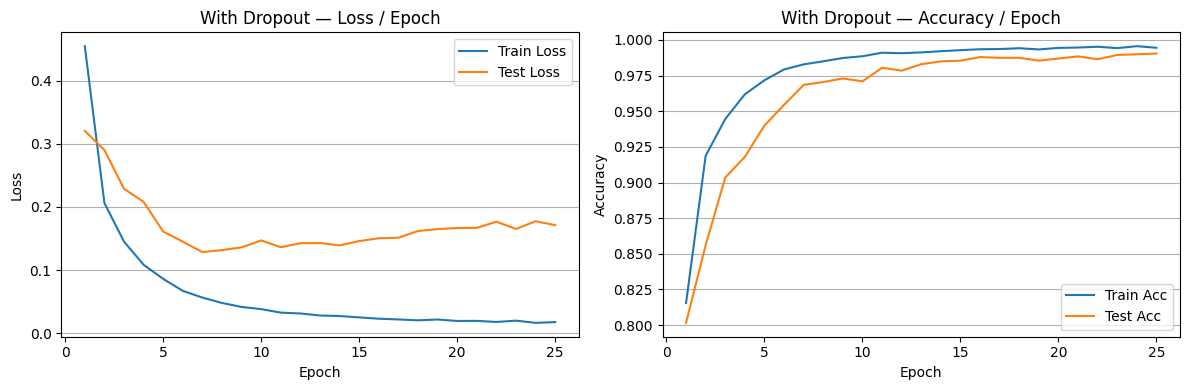

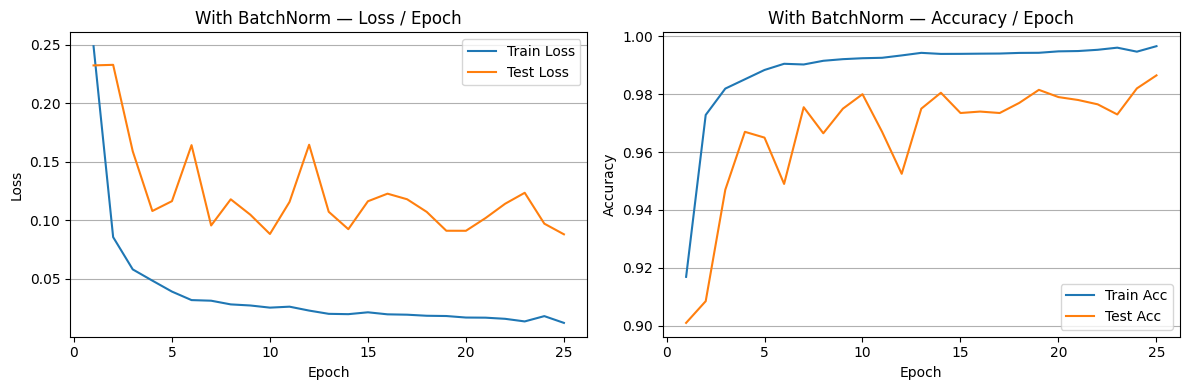

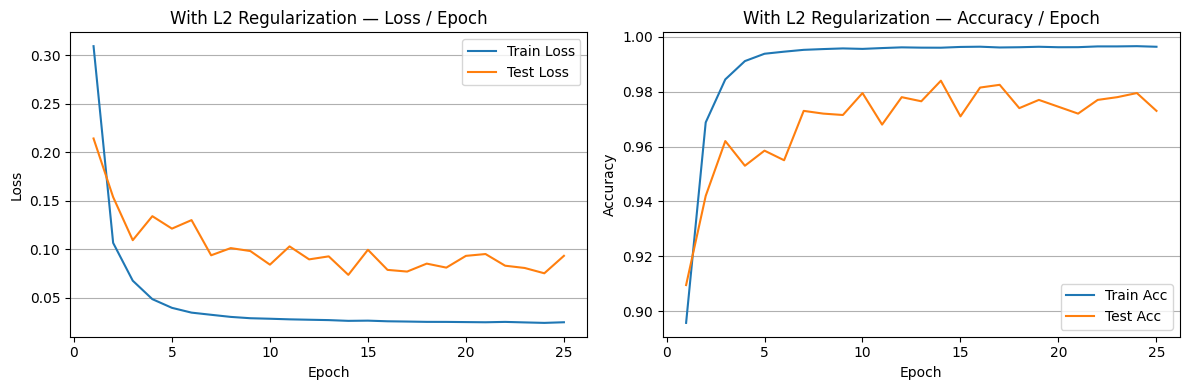

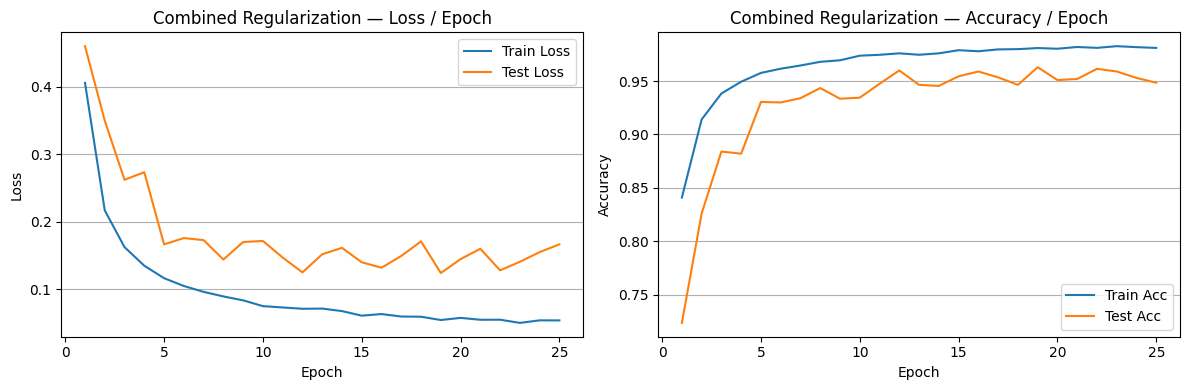

In [46]:
# -----------------------
# 10) Plot Loss and Accuracy curves for each model
# -----------------------
for name, h in histories.items():
    epochs_range = range(1, len(h['train_loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, h['train_loss'], label='Train Loss')
    plt.plot(epochs_range, h['test_loss'], label='Test Loss')
    plt.title(f"{name} — Loss / Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, h['train_acc'], label='Train Acc')
    plt.plot(epochs_range, h['test_acc'], label='Test Acc')
    plt.title(f"{name} — Accuracy / Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()


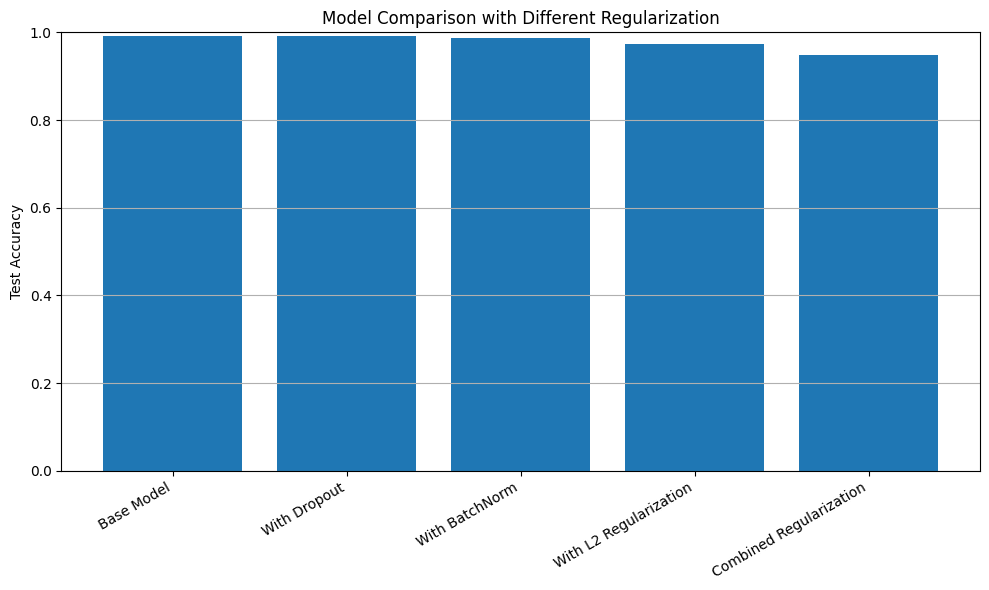

In [47]:
# -----------------------
# 11) Final comparison bar chart
# -----------------------
plt.figure(figsize=(10,6))
names = list(final_test_accuracies.keys())
values = [final_test_accuracies[n] for n in names]
plt.bar(names, values)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison with Different Regularization")
plt.xticks(rotation=30, ha='right')
plt.ylim(0,1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [48]:
# -----------------------
# 12) Classification report for the best model
# -----------------------
best_name = max(final_test_accuracies, key=final_test_accuracies.get)
print("Best model:", best_name, "with accuracy:", final_test_accuracies[best_name])

best_model = trained_models[best_name]
test_loss, test_acc, all_preds, all_labels = evaluate(best_model, test_loader, criterion, device)
print("\nClassification report (best model):\n")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Save the trained best model (optional in Kaggle)
torch.save(best_model.state_dict(), 'best_model.pth')


Best model: Base Model with accuracy: 0.9915

Classification report (best model):

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        22
              No Failure       1.00      1.00      1.00      1930
      Overstrain Failure       0.83      0.94      0.88        16
           Power Failure       1.00      0.89      0.94        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.86      0.67      0.75         9

                accuracy                           0.99      2000
               macro avg       0.78      0.75      0.76      2000
            weighted avg       0.99      0.99      0.99      2000

